In [1]:

from sympy import *

In [2]:
x, y, z = symbols('x y z', real = True)
Ax, Ay, Az = symbols('Ax Ay Az', real = True)
Bx, By, Bz = symbols('Bx By Bz', real = True)
alpha, beta = symbols('alpha beta', real = True, positive = True)

In [3]:
Lmax = 2

Gauss = Matrix([(x-Ax)**n * exp(-alpha*(x-Ax)**2) for n in range(Lmax)])
Hermite = Matrix([simplify(diff(exp(-alpha*(x-Ax)**2), Ax, n)) for n in range(Lmax)])
for g,h in zip(Gauss,Hermite):
    print(g,h)

exp(-alpha*(-Ax + x)**2) exp(-alpha*(Ax - x)**2)
(-Ax + x)*exp(-alpha*(-Ax + x)**2) -2*alpha*(Ax - x)*exp(-alpha*(Ax - x)**2)


In [4]:
from functools import lru_cache

@lru_cache(maxsize = None)
def getCkn(k,n,expo):
    if k==0==n :
        return sympify(1)
    if (k == 0) and (n == 1):
        return sympify(0)
    if (k ==1 ) and (n == 1):
        return (1 / (2 * expo))
    if (k > n): 
        return sympify (0)
    if (k < 0):
        return sympify (0)
    else:
        return (1 / (2 * expo))* getCkn(k-1,n-1, expo) + (k + 1) * getCkn(k+1, n-1, expo)
Lmax = 10      
coefs = Matrix([getCkn(k, Lmax, alpha) for k in range(Lmax)])


In [5]:
g1 = exp(-alpha * (x-Ax)**2)
g2 = exp(-beta * (x-Bx)**2)
S00 = simplify(integrate (g1*g2,(x,-oo,+oo)))
S00

sqrt(pi)*exp(alpha*(-Ax**2 + 2*Ax*Bx - Bx**2 + alpha*(Ax - Bx)**2/(alpha + beta)))/sqrt(alpha + beta)

In [6]:
Lmax = 3
derivatives = {(0,0): S00}
for k in range(Lmax + 1 ):
    derivatives[k+1,0] = diff(derivatives[k,0], Ax)
    for l in range(Lmax +1):
        derivatives[k,l+1] = diff(derivatives[k,l], Bx)

def getSij(i,j):
    Overlap = sympify(0)
    for k in range(i+1):
        for l in range(j+1):
            Overlap += getCkn(k,i,alpha)*getCkn(l,j,beta)*derivatives[k,l] # diff(diff(S00,(Ax,k)),(Bx,l))
    Overlap = factor_terms(Overlap)
    return Overlap

In [7]:
getSij(1,1)

sqrt(pi)*(2*alpha*(-Ax + Bx + alpha*(Ax - Bx)/(alpha + beta))*(Ax - Bx + alpha*(-Ax + Bx)/(alpha + beta)) - alpha/(alpha + beta) + 1)*exp(alpha*(-Ax**2 + 2*Ax*Bx - Bx**2 + alpha*(Ax - Bx)**2/(alpha + beta)))/(2*beta*sqrt(alpha + beta))

In [8]:
AB_sum, AB_diff, AB_diff_squared, AB_product = symbols('AB_sum AB_diff AB_diff_squared AB_product', real = True)

subsdict = {alpha+beta : AB_sum,
           Ax**2-2*Ax*Bx+Bx**2: AB_diff_squared,
           Ax-Bx : AB_diff,
           alpha*beta : AB_product}
def generateSij(Lmax):
    Sij = {}
    for i in range(Lmax+1):
        for j in range(Lmax+1):
            overlap = getSij(i,j)
            overlap = overlap.subs(subsdict)
            Sij[(i,j)] = overlap
    return Sij

In [9]:
Sij = generateSij(3)
for key,value in Sij.items():
    print(key,value)

(0, 0) sqrt(pi)*exp(alpha*(AB_diff**2*alpha/AB_sum - AB_diff_squared))/sqrt(AB_sum)
(0, 1) sqrt(pi)*alpha*(AB_diff - AB_diff*alpha/AB_sum)*exp(alpha*(AB_diff**2*alpha/AB_sum - AB_diff_squared))/(sqrt(AB_sum)*beta)
(0, 2) sqrt(pi)*(alpha*(2*alpha*(AB_diff - AB_diff*alpha/AB_sum)**2 - 1 + alpha/AB_sum)/beta + 1)*exp(alpha*(AB_diff**2*alpha/AB_sum - AB_diff_squared))/(2*sqrt(AB_sum)*beta)
(0, 3) sqrt(pi)*alpha*(AB_diff - AB_diff*alpha/AB_sum)*(alpha*(2*alpha*(AB_diff - AB_diff*alpha/AB_sum)**2 - 3 + 3*alpha/AB_sum)/beta + 3)*exp(alpha*(AB_diff**2*alpha/AB_sum - AB_diff_squared))/(2*sqrt(AB_sum)*beta**2)
(1, 0) sqrt(pi)*(-AB_diff + AB_diff*alpha/AB_sum)*exp(alpha*(AB_diff**2*alpha/AB_sum - AB_diff_squared))/sqrt(AB_sum)
(1, 1) sqrt(pi)*(2*alpha*(-AB_diff + AB_diff*alpha/AB_sum)*(AB_diff - AB_diff*alpha/AB_sum) + 1 - alpha/AB_sum)*exp(alpha*(AB_diff**2*alpha/AB_sum - AB_diff_squared))/(2*sqrt(AB_sum)*beta)
(1, 2) sqrt(pi)*(-AB_diff + AB_diff*alpha/AB_sum + alpha*(2*alpha*(-AB_diff + AB_diff

In [10]:
def write_Sij(Lmax, path = ""):
    Sij = generateSij(Lmax)
    
    with open(path+"S.py", "w") as file:
        file.write("from numpy import sqrt, exp, pi \n")
        file.write("def Sij(i, j, alpha, beta, Ax, Bx):\n")
        file.write("    AB_diff = Ax - Bx \n")
        file.write("    AB_diff_squared = AB_diff**2 \n")
        file.write("    AB_sum = alpha + beta \n")
        file.write("    AB_product = alpha * beta \n")

        for (key,value) in Sij.items():
            file.write("    if (i,j) == ({}, {}): \n".format(str(key[0]),str(key[1])))
            file.write("        return {}\n".format(str(value)))
        

In [11]:
write_Sij(3)

In [12]:
import numpy as np
import S
class gaussian:
    def __init__(self, A, exps, coefs, ijk):
        self.A = A
        self.exps = exps
        self.coefs = coefs
        self.ijk = ijk
        self.get_norm_constants()
    
    def setA(self, r):
        self.A = r
        
    def get_norm_constants(self,):
        self.norm_const = np.zeros(self.coefs.shape)
        for i, alpha in enumerate(self.exps):
                a = S.Sij(self.ijk[0], self.ijk[0], alpha, alpha, self.A[0], self.A[0])
                b = S.Sij(self.ijk[1], self.ijk[1], alpha, alpha, self.A[1], self.A[1])
                c = S.Sij(self.ijk[2], self.ijk[2], alpha, alpha, self.A[2], self.A[2])
                self.norm_const[i] = 1./np.sqrt(a* b* c)
            
    def getS(self, other):
        overlap = 0.0
        for ca, alphaa, normi in zip (self.coefs, self.exps, self.norm_const):
            for cb, alphab, normj in zip (other.coefs, other.exps, other.norm_const):
                a = S.Sij(self.ijk[0], other.ijk[0], alphaa, alphab, self.A[0], other.A[0])
                b = S.Sij(self.ijk[1], other.ijk[1], alphaa, alphab, self.A[1], other.A[1])
                c = S.Sij(self.ijk[2], other.ijk[2], alphaa, alphab, self.A[2], other.A[2])
                overlap += ca* cb* a * b * c * normi * normj
        return overlap
    
    def __str__(self,):
        string = ''.join([f"------ Gaussian Function -------\n",
                          f"Center        =  {self.A} \n",
                          f"Exponents     =  {self.exps} \n",
                          f"Coefficients  =  {self.coefs} \n",
                          f"ijk           =  {self.ijk} \n"])
        return string
                


In [13]:
s1 = gaussian(np.zeros(3), np.asarray([1.0, 0.5]), np.asarray([1.0, -1.0]), (0,0,1))
s2 = gaussian(np.zeros(3), np.asarray([1.0]), np.asarray([1.0]), (0,0,1))
zarray = np.linspace(0,10,100)
overlapint = np.zeros(zarray.shape)
for ind, z in enumerate(zarray):
    A = np.asarray([0.0,0.0,z])
    s2.setA(A)
    overlapint[ind] = s1.getS(s2)


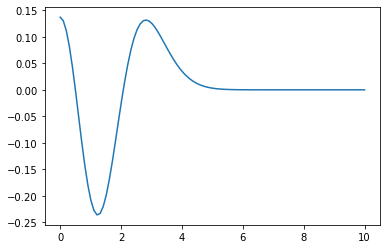

In [14]:
import matplotlib.pyplot as plt
plt.plot(zarray, overlapint)

In [15]:
import json
from pprint import pprint

In [34]:
class basisSet:
    def __init__(self, name = "sto-3g"):
        self.name = name

    def get(self, elementlist, path = ""):
        basispath = path + self.name + ".json"
        self.basis_functions = {}
        for element in elementlist:
            self.basis_functions[element] = self.getBasisFunctions(element, basispath)

    def getBasisFunctions(self, atnum, path):
        ijk = {0: [(0,0,0)], 1: [(1,0,0), (0,1,0), (0,0,1)]}
        basis_functions = []
        try: 
            with open(path, "r") as f:
                basis_data = json.load(f)
        except FileNotFoundError: 
            print("Error: Basis set file not found!")
            return None

        basis_function_data = basis_data['elements'][str(atnum)]['electron_shells']

        for bfdata in basis_function_data:
            exps = np.array([float(e) for e in bfdata['exponents']])
            for ang_mom in bfdata['angular_momentum']:
                coefs = np.array([float(e) for e in bfdata['coefficients'][ang_mom]])
                for ikm in ijk[ang_mom]:
                    basis_function = gaussian(np.zeros(3), exps, coefs, ikm)
                    basis_functions.append(basis_function)
        return basis_functions

In [35]:
class atom:
    atomic_number = {"H": 1,
                     "C": 6,
                     "N":7,
                     "O":8}
    def __init__(self, symbol, coord):
        self.symbol = symbol
        self.coord = coord
    
    def get_atomic_number(self):
        return self.atomic_number[self.symbol]
    
    def __str__(self,):
        string = f"{self.symbol} {' '.join(map(lambda c : f'{c : .6f}', self.coord))}\n"
        return string

In [36]:
c= atom("C", np.asarray([1.0,0.0,0.0]))
print(c)

C  1.000000  0.000000  0.000000



In [40]:
from copy import deepcopy
a0 = 0.529177210903

class molecule:
    def __init__(self, atomlist):
        self.atomlist = atomlist

    def read_from_XYZ(self, path = "ethene.xyz"):
        data = np.loadtxt(path, skiprows = 2, dtype = {'names' : ('symbols', 'coords'), 
                                                         'formats' : ('O','3float64')}, )
        self.atomlist = [atom(s, c/a0) for s, c in zip(data['symbols'], data['coords'])]
        
    def __str__(self):
        return 31*'-'+'\n'+''.join([at.__str__() for at in self.atomlist])+31*'-'+'\n'
    
    def get_basis(self, name = 'sto-3g'):
        self.basis_functions = []
        basis = basisSet(name)
        elements = list(set([at.get_atomic_number() for at in self.atomlist]))
        basis.get(elements)
        for at in self.atomlist:
            atom_basis = basis.basis_functions[at.get_atomic_number()]
            for gauss in atom_basis:
                gauss_copy = deepcopy(gauss)
                gauss_copy.setA(at.coord)
                self.basis_functions.append(gauss_copy)
                
    def getS_slow(self,):
        nbf = len(self.basis_functions)
        self.S = np.zeros((nbf, nbf))
        for i in range(nbf):
            for j in range(i,nbf):
                self.S[i,j] = self.basis_functions[i].getS(self.basis_functions[j])
                self.S[j,i] = self.S[i,j]
        

    def getS(self):
        nbf = len(self.basis_functions)
        i, j = np.triu_indices(nbf)
        S = np.array([self.basis_functions[x].getS(self.basis_functions[y]) for x, y in zip(i,j) ])
        self.S = np.zeros((nbf, nbf))
        self.S[i,j] = S
        self.S[j,i] = S
        

In [41]:
ethene = molecule([])
ethene.read_from_XYZ(path = "ethene.xyz")
ethene.get_basis()
ethene.getS_slow()

In [43]:
import pyscf
from pyscf import gto
mol = gto.M(atom = "ethene.xyz", basis = "sto-3g")
S_pyscf = mol.intor("int1e_ovlp", hermi = 1)
V_pyscf = mol.intor("int1e_nuc", hermi = 1)

print(np.allclose(S_pyscf, ethene.S))

True


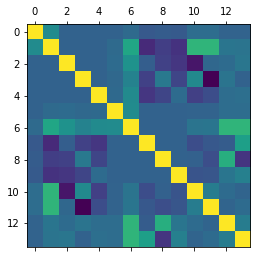

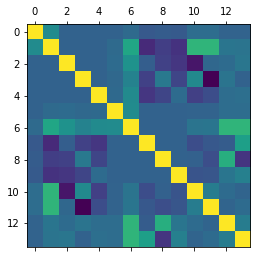

In [44]:
plt.matshow(S_pyscf)
plt.matshow(ethene.S)

# The calculation of electron-nuclear integrals

In [45]:
x, y, z = symbols('x y z', real = True)
Ax, Ay, Az = symbols('Ax Ay Az', real = True)
Bx, By, Bz = symbols('Bx By Bz', real = True)
Cx, Cy, Cz = symbols('Cx Cy Cz', real = True)
alpha, beta = symbols('alpha beta', real = True, positive = True)
Px = (alpha * Ax + beta * Bx)/(alpha + beta)
Py = (alpha * Ay + beta * By)/(alpha + beta)
Pz = (alpha * Az + beta * Bz)/(alpha + beta)
RPC = ((Cx-Px)**2 + (Cy-Py)**2 + (Cz-Pz)**2)
RAB = ((Ax-Bx)**2 + (Ay-By)**2 + (Az-Bz)**2)
#n = symbols('n', integer = True)

In [46]:
class boys(Function):
    @classmethod
    def eval(cls, n, x):
        pass
    
    def fdiff(self, argindex):
        return -boys(self.args[0] +1, self.args[1])

In [47]:
V00 = ((2* pi)/(alpha + beta))*exp(-alpha*beta*RAB/(alpha + beta))*boys(0, (alpha + beta)*RPC)

In [48]:
V00

2*pi*exp(-alpha*beta*((Ax - Bx)**2 + (Ay - By)**2 + (Az - Bz)**2)/(alpha + beta))*boys(0, (alpha + beta)*((Cx - (Ax*alpha + Bx*beta)/(alpha + beta))**2 + (Cy - (Ay*alpha + By*beta)/(alpha + beta))**2 + (Cz - (Az*alpha + Bz*beta)/(alpha + beta))**2))/(alpha + beta)

In [49]:
def generate_triple(ijk):
    new = [ijk[:] for _ in range(3)]
    for i in range(3):
        new[i][i]+=1
    return new

def generate_derivative(expr, var):
    return factor_terms(diff(expr, var))
#return [diff(expr, x) for x in var]


In [50]:
def generate_tree(Lmax, der_init, var):
    ijk = [[0,0,0]]
    derivatives = [der_init]
    
    ijk_old = ijk[:]
    derivatives_old = derivatives[:]
    
    for _ in range(Lmax):
        
        ijk_new = []
        derivatives_new = []
        
        for item, expr in zip(ijk_old, derivatives_old):
            new_ijk = generate_triple(item)
            for index, n in enumerate(new_ijk):
                if n not in ijk:
                    ijk.append(n)
                    ijk_new.append(n)
                    new_der = generate_derivative(expr, var[index])
                    derivatives.append(new_der)
                    derivatives_new.append(new_der)
            ijk_old = ijk_new[:]
            derivatives_old = derivatives_new[:]
    return ijk, derivatives
            


In [51]:
Lmax = 1
ijk, d_ijk = generate_tree(Lmax, V00, (Ax, Ay, Az))
ijklmn = []
derivatives_ijklmn = []
for i, d in zip(ijk, d_ijk):
    lmn, d_lmn = generate_tree(Lmax, d, (Bx, By, Bz))
    for j, e in zip(lmn, d_lmn):
        ijklmn.append(i+j)
        derivatives_ijklmn.append(e)
derivatives_dict = {tuple(i): d for i, d in zip(ijklmn, derivatives_ijklmn)}


In [52]:
#for key, value in derivatives_dict.items():
#    print(key, factor_terms(value))

In [53]:
def get_v_ijklmn(i,j,k,l,m,n):
    vint = 0
    for o in range(i+1):
        for p in range(j+1):
            for q in range(k+1):
                for r in range(l+1):
                    for s in range(m+1):
                        for t in range(n+1):
                            vint += getCkn(o, i, alpha)*\
                                    getCkn(p, j, alpha)*\
                                    getCkn(q, k, alpha)*\
                                    getCkn(r, l, beta)*\
                                    getCkn(s, m, beta)*\
                                    getCkn(t, n, beta)*\
                                    derivatives_dict[(o,p,q,r,s,t)]
    return factor_terms(vint)

In [54]:
get_v_ijklmn(0,0,0,0,0,0)

2*pi*exp(-alpha*beta*((Ax - Bx)**2 + (Ay - By)**2 + (Az - Bz)**2)/(alpha + beta))*boys(0, (alpha + beta)*((Cx - (Ax*alpha + Bx*beta)/(alpha + beta))**2 + (Cy - (Ay*alpha + By*beta)/(alpha + beta))**2 + (Cz - (Az*alpha + Bz*beta)/(alpha + beta))**2))/(alpha + beta)

In [55]:
p, q, rAB, pRPC = symbols('p q rAB pRPC', real = True)
keys = derivatives_dict.keys()
vij_dict = {}
subsdict = {alpha+beta:p,alpha*beta:q, 
            (Ax - Bx)**2 + (Ay - By)**2 + (Az - Bz)**2:rAB,
            (alpha + beta)*((Cx - (Ax*alpha + Bx*beta)/(alpha + beta))**2 + (Cy - (Ay*alpha + By*beta)/(alpha + beta))**2 + (Cz - (Az*alpha + Bz*beta)/(alpha + beta))**2): pRPC}
for key in keys:
    print(key)
    vij = get_v_ijklmn(*key)
    vij_dict[key] = vij.subs(subsdict)

(0, 0, 0, 0, 0, 0)
(0, 0, 0, 1, 0, 0)
(0, 0, 0, 0, 1, 0)
(0, 0, 0, 0, 0, 1)
(1, 0, 0, 0, 0, 0)
(1, 0, 0, 1, 0, 0)
(1, 0, 0, 0, 1, 0)
(1, 0, 0, 0, 0, 1)
(0, 1, 0, 0, 0, 0)
(0, 1, 0, 1, 0, 0)
(0, 1, 0, 0, 1, 0)
(0, 1, 0, 0, 0, 1)
(0, 0, 1, 0, 0, 0)
(0, 0, 1, 1, 0, 0)
(0, 0, 1, 0, 1, 0)
(0, 0, 1, 0, 0, 1)


In [56]:
vij_dict[(0,0,0,0,0,0)]

2*pi*exp(-q*rAB/p)*boys(0, pRPC)/p

In [57]:
def write_V_elnuc(path = "./"):
    with open(path+"V.py", "w") as file:
        file.write("from scipy.special import hyp1f1 \n")
        file.write("from numpy import sqrt, exp, pi, dot \n")
        file.write("def boys(n,t):\n")
        file.write("    return hyp1f1(n+0.5, n+1.5, -t)/(2.*n+1.)\n")
        file.write("def Vij(i,j,k,l,m,n,alpha,beta,A,B,C):\n")
        file.write("    p = alpha + beta\n")
        file.write("    q = alpha * beta\n")
        file.write("    AB = A-B\n")
        file.write("    rAB = dot(AB, AB)\n")
        file.write("    P = (alpha*A+beta*B)/p \n")
        file.write("    PC = P-C \n")
        file.write("    pRPC = p*dot(PC,PC) \n")
        file.write("    Ax,Ay,Az = A[0], A[1], A[2] \n")
        file.write("    Bx,By,Bz = B[0], B[1], B[2] \n")
        file.write("    Cx,Cy,Cz = C[0], C[1], C[2] \n")
        for key, value in vij_dict.items():
            file.write(f"    if (i,j,k,l,m,n) == {key}:\n")
            file.write(f"          return {value}\n")

In [58]:
write_V_elnuc()

In [59]:
import numpy as np
import S
import V
class gaussian:
    def __init__(self, A, exps, coefs, ijk):
        self.A = A
        self.exps = exps
        self.coefs = coefs
        self.ijk = ijk
        self.get_norm_constants()
    
    def setA(self, r):
        self.A = r
        
    def get_norm_constants(self,):
        self.norm_const = np.zeros(self.coefs.shape)
        for i, alpha in enumerate(self.exps):
                a = S.Sij(self.ijk[0], self.ijk[0], alpha, alpha, self.A[0], self.A[0])
                b = S.Sij(self.ijk[1], self.ijk[1], alpha, alpha, self.A[1], self.A[1])
                c = S.Sij(self.ijk[2], self.ijk[2], alpha, alpha, self.A[2], self.A[2])
                self.norm_const[i] = 1./np.sqrt(a* b* c)
            
    def getS(self, other):
        overlap = 0.0
        for ca, alphaa, normi in zip (self.coefs, self.exps, self.norm_const):
            for cb, alphab, normj in zip (other.coefs, other.exps, other.norm_const):
                a = S.Sij(self.ijk[0], other.ijk[0], alphaa, alphab, self.A[0], other.A[0])
                b = S.Sij(self.ijk[1], other.ijk[1], alphaa, alphab, self.A[1], other.A[1])
                c = S.Sij(self.ijk[2], other.ijk[2], alphaa, alphab, self.A[2], other.A[2])
                overlap += ca* cb* a * b * c * normi * normj
        return overlap
    
    def getVC(self, other, RC):
        ven = 0.0
        for ca, alphaa, normi in zip (self.coefs, self.exps, self.norm_const):
            for cb, alphab, normj in zip (other.coefs, other.exps, other.norm_const):
                ven +=  ca*cb*normi*normj*V.Vij(self.ijk[0],self.ijk[1],self.ijk[2],
                              other.ijk[0],other.ijk[1],other.ijk[2],
                              alphaa, alphab, self.A, other.A, RC )
        return ven
    
    def __str__(self,):
        string = ''.join([f"------ Gaussian Function -------\n",
                          f"Center        =  {self.A} \n",
                          f"Exponents     =  {self.exps} \n",
                          f"Coefficients  =  {self.coefs} \n",
                          f"ijk           =  {self.ijk} \n"])
        return string
                


In [60]:
s1 = gaussian(np.zeros(3), np.asarray([1.0, 0.5]), np.asarray([1.0, -1.0]), (0,0,1))
s2 = gaussian(np.zeros(3), np.asarray([1.0]), np.asarray([1.0]), (0,0,1))
s1.getVC(s2, np.array([1.,1.,1.]))

0.08317781588111611

In [61]:
vij_dict[(0,0,0,0,0,0)]

2*pi*exp(-q*rAB/p)*boys(0, pRPC)/p

In [62]:
from copy import deepcopy
a0 = 0.529177210903

class molecule:
    def __init__(self, atomlist):
        self.atomlist = atomlist

    def read_from_XYZ(self, path = "/Users/rolandmitric/ethene.xyz"):
        data = np.loadtxt(path, skiprows = 2, dtype = {'names' : ('symbols', 'coords'), 
                                                         'formats' : ('O','3float64')}, )
        self.atomlist = [atom(s, c/a0) for s, c in zip(data['symbols'], data['coords'])]
        
    def __str__(self):
        return 31*'-'+'\n'+''.join([at.__str__() for at in self.atomlist])+31*'-'+'\n'
    
    def get_basis(self, name = 'sto-3g'):
        self.basis_functions = []
        basis = basisSet(name)
        elements = list(set([at.get_atomic_number() for at in self.atomlist]))
        basis.get(elements)
        for at in self.atomlist:
            atom_basis = basis.basis_functions[at.get_atomic_number()]
            for gauss in atom_basis:
                gauss_copy = deepcopy(gauss)
                gauss_copy.setA(at.coord)
                self.basis_functions.append(gauss_copy)
                
    def getS_slow(self,):
        nbf = len(self.basis_functions)
        self.S = np.zeros((nbf, nbf))
        for i in range(nbf):
            for j in range(i,nbf):
                self.S[i,j] = self.basis_functions[i].getS(self.basis_functions[j])
                self.S[j,i] = self.S[i,j]
        

    def getS(self):
        nbf = len(self.basis_functions)
        i, j = np.triu_indices(nbf)
        S = np.array([self.basis_functions[x].getS(self.basis_functions[y]) for x, y in zip(i,j) ])
        self.S = np.zeros((nbf, nbf))
        self.S[i,j] = S
        self.S[j,i] = S
        
    def getVij(self,i,j):
        vint = 0.
        for at in self.atomlist:
            vint = vint- at.get_atomic_number()*self.basis_functions[i].getVC(self.basis_functions[j], at.coord)
        return vint
        
    def getV(self):
        nbf = len(self.basis_functions)
        self.V = np.zeros((nbf, nbf))
        for i in range(nbf):
            for j in range(i,nbf):
                self.V[i,j] = self.getVij(i,j)
                self.V[j,i] = self.V[i,j]
        

In [65]:
ethene = molecule([])
ethene.read_from_XYZ(path = "ethene.xyz")
ethene.get_basis()
ethene.getS_slow()
ethene.getV()

In [67]:
import pyscf
from pyscf import gto
mol = gto.M(atom = "ethene.xyz", basis = "sto-3g")
S_pyscf = mol.intor("int1e_ovlp", hermi = 1)
V_pyscf = mol.intor("int1e_nuc", hermi = 1)
np.allclose(V_pyscf, ethene.V)

True

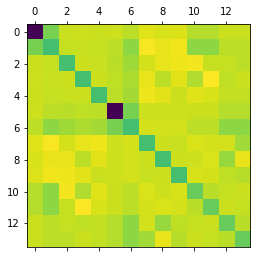

In [68]:
plt.matshow(ethene.V)

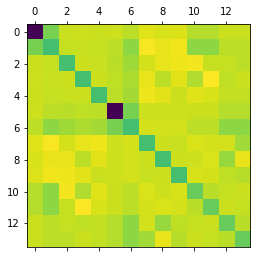

In [69]:
plt.matshow(V_pyscf)

In [70]:
gamma, delta = symbols('gamma delta', real = True, positive = True)
Cx, Cy, Cz = symbols('Cx Cy Cz', real = True)
Dx, Dy, Dz = symbols('Dx Dy Dz', real = True)

p = alpha + beta
q = gamma + delta
pq = p + q
rho = p*q/pq

Px = (alpha*Ax + beta*Bx)/p
Py = (alpha*Ay + beta*By)/p
Pz = (alpha*Az + beta*Bz)/p

Qx = (gamma*Cx + delta*Dx)/q
Qy = (gamma*Cy + delta*Dy)/q
Qz = (gamma*Cz + delta*Dz)/q

RAB = ((Ax-Bx)**2+(Ay-By)**2+(Az-Bz)**2)
RCD = ((Cx-Dx)**2+(Cy-Dy)**2+(Cz-Dz)**2)
RPQ = ((Px-Qx)**2+(Py-Qy)**2+(Pz-Qz)**2)

In [71]:
G00 = (2*pi/rho)*(pi/(p+q))**(3/2)*exp(-(alpha*beta/p)*RAB)*exp(-(gamma*delta/q)*RCD)*boys(0, rho*RPQ)

In [72]:
G00

2*pi**2.5*exp(-alpha*beta*((Ax - Bx)**2 + (Ay - By)**2 + (Az - Bz)**2)/(alpha + beta))*exp(-delta*gamma*((Cx - Dx)**2 + (Cy - Dy)**2 + (Cz - Dz)**2)/(delta + gamma))*boys(0, (alpha + beta)*(delta + gamma)*((-(Cx*gamma + Dx*delta)/(delta + gamma) + (Ax*alpha + Bx*beta)/(alpha + beta))**2 + (-(Cy*gamma + Dy*delta)/(delta + gamma) + (Ay*alpha + By*beta)/(alpha + beta))**2 + (-(Cz*gamma + Dz*delta)/(delta + gamma) + (Az*alpha + Bz*beta)/(alpha + beta))**2)/(alpha + beta + delta + gamma))/((alpha + beta)*(delta + gamma)*(alpha + beta + delta + gamma)**0.5)

In [73]:
Lmax = 1
ijk, d_ijk = generate_tree(Lmax, G00, (Ax, Ay, Az))
ijklmn = []
derivatives_ijklmn = []
for i, d in zip(ijk, d_ijk):
    lmn, d_lmn = generate_tree(Lmax, d, (Bx, By, Bz))
    for j, e in zip(lmn, d_lmn):
        ijklmn.append(i+j)
        derivatives_ijklmn.append(e)
        
ijklmnopq = []
derivatives_ijklmnopq = []
for i, d in zip(ijklmn, derivatives_ijklmn):
    opq, d_opq = generate_tree(Lmax, d, (Cx, Cy, Cz))
    for j, e in zip(opq, d_opq):
        ijklmnopq.append(i+j)
        derivatives_ijklmnopq.append(e)
        
ijklmnopqrst = []
derivatives_ijklmnopqrst = []
for i, d in zip(ijklmnopq, derivatives_ijklmnopq):
    rst, d_rst = generate_tree(Lmax, d, (Dx, Dy, Dz))
    for j, e in zip(rst, d_rst):
        ijklmnopqrst.append(i+j)
        derivatives_ijklmnopqrst.append(e)       

derivatives_dict = {tuple(i): d for i, d in zip(ijklmnopqrst, derivatives_ijklmnopqrst)}


In [74]:
def get_twoel(m,n,o,p,q,r,s,t,u,v,w,x):
    eri = 0
    for a in range(m+1):
        for b in range(n+1):
            for c in range(o+1):
                for d in range(p+1):
                    for e in range(q+1):
                        for f in range(r+1):
                            for g in range(s+1):
                                for h in range(t+1):
                                    for i in range(u+1):
                                        for j in range(v+1):
                                            for k in range(w+1):
                                                for l in range(x+1):
                                                    eri +=  getCkn(a, m, alpha)*\
                                                            getCkn(b, n, alpha)*\
                                                            getCkn(c, o, alpha)*\
                                                            getCkn(d, p, beta)*\
                                                            getCkn(e, q, beta)*\
                                                            getCkn(f, r, beta)*\
                                                            getCkn(g, s, gamma)*\
                                                            getCkn(h, t, gamma)*\
                                                            getCkn(i, u, gamma)*\
                                                            getCkn(j, v, delta)*\
                                                            getCkn(k, w, delta)*\
                                                            getCkn(l, x, delta)*\
                                                            derivatives_dict[(a,b,c,d,e,f,g,h,i,j,k,l)]
    return factor_terms(eri)

    

In [75]:
p, q, r, s, rAB, rCD, pRPQ = symbols('p q r s rAB rCD pRPQ', real = True)
keys = derivatives_dict.keys()
subsdict = {alpha + beta: p,
           gamma+delta: r,
           (Ax - Bx)**2 + (Ay - By)**2 + (Az - Bz)**2 : rAB,
           (Cx - Dx)**2 + (Cy - Dy)**2 + (Cz - Dz)**2 : rCD,
            (alpha + beta)*(delta + gamma)*((-(Cx*gamma + Dx*delta)/(delta + gamma) + 
                                             (Ax*alpha + Bx*beta)/(alpha + beta))**2 + 
                                            (-(Cy*gamma + Dy*delta)/(delta + gamma) + 
                                             (Ay*alpha + By*beta)/(alpha + beta))**2 + 
                                            (-(Cz*gamma + Dz*delta)/(delta + gamma) + 
                                             (Az*alpha + Bz*beta)/(alpha + beta))**2)/(alpha + beta + delta + gamma) : pRPQ
           }
twoel_dict = {}
for key in keys:
    print(key)
    twoel = get_twoel(*key)
    twoel_dict[key] = twoel.subs(subsdict)

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)
(0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0)
(0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0)
(0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1)
(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0)
(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1)
(0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0)
(0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1)
(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0)
(0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0)
(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0)
(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1)
(0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0)
(0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0)
(0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0)
(0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1)
(0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0)
(0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0)
(0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0)
(

(0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0)
(0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1)
(0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0)
(0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0)
(0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0)
(0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1)
(0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0)
(0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0)
(0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0)
(0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1)
(0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0)
(0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0)
(0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0)
(0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1)
(0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0)
(0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0)
(0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0)
(0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1)
(0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0)
(0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0)
(0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0)
(0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1)
(0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0)
(0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0)
(0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0)
(0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1)
(0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0)
(

In [76]:
twoel_dict[tuple(9*[0]+[0,0,1])]

2*pi**2.5*(-gamma*(-Cz + Dz)*boys(0, pRPQ)/(p*r*(p + r)**0.5) + ((-Cz*gamma - Dz*delta)/r + (Az*alpha + Bz*beta)/p)*boys(1, pRPQ)/(p + r)**1.5)*exp(-alpha*beta*rAB/p)*exp(-delta*gamma*rCD/r)/r

In [77]:
def write_twoel(path = "./"):
    with open(path+"twoel.py", "w") as file:
        file.write("from scipy.special import hyp1f1 \n")
        file.write("from numpy import sqrt, exp, pi, dot \n")
        file.write("def boys(n,t):\n")
        file.write("    return hyp1f1(n+0.5, n+1.5, -t)/(2.*n+1.)\n")
        file.write("def twoel(ix,jx,kx,lx,mx,nx,ox,px,qx,rx,sx,tx, alpha,beta,gamma, delta, A,B,C,D):\n")
        file.write("    p = alpha + beta\n")
        file.write("    r = gamma + delta\n")
        file.write("    rho = p*r/(p+r)\n")

        file.write("    AB = A-B\n")
        file.write("    CD = C-D\n")
        file.write("    rAB = dot(AB, AB)\n")
        file.write("    rCD = dot(CD, CD)\n")

        file.write("    P = (alpha*A+beta*B)/p \n")
        file.write("    Q = (gamma*C+delta*D)/r \n")
        file.write("    PQ = P-Q \n")
        file.write("    pRPQ = rho*dot(PQ,PQ) \n")
        file.write("    Ax,Ay,Az = A[0], A[1], A[2] \n")
        file.write("    Bx,By,Bz = B[0], B[1], B[2] \n")
        file.write("    Cx,Cy,Cz = C[0], C[1], C[2] \n")
        file.write("    Dx,Dy,Dz = D[0], D[1], D[2] \n")

        for key, value in twoel_dict.items():
            file.write(f"    if (ix,jx,kx,lx,mx,nx,ox,px,qx,rx,sx,tx) == {key}:\n")
            file.write(f"          return {value}\n")

In [78]:
write_twoel()

In [85]:
import numpy as np
import S
import V
import twoel
import importlib
importlib.reload(twoel)
importlib.reload(S)

class gaussian:
    def __init__(self, A, exps, coefs, ijk):
        self.A = A
        self.exps = exps
        self.coefs = coefs
        self.ijk = ijk
        self.get_norm_constants()
    
    def setA(self, r):
        self.A = r
        
    def get_norm_constants(self,):
        self.norm_const = np.zeros(self.coefs.shape)
        for i, alpha in enumerate(self.exps):
                a = S.Sij(self.ijk[0], self.ijk[0], alpha, alpha, self.A[0], self.A[0])
                b = S.Sij(self.ijk[1], self.ijk[1], alpha, alpha, self.A[1], self.A[1])
                c = S.Sij(self.ijk[2], self.ijk[2], alpha, alpha, self.A[2], self.A[2])
                self.norm_const[i] = 1./np.sqrt(a* b* c)
            
    def getS(self, other):
        overlap = 0.0
        for ca, alphaa, normi in zip (self.coefs, self.exps, self.norm_const):
            for cb, alphab, normj in zip (other.coefs, other.exps, other.norm_const):
                a = S.Sij(self.ijk[0], other.ijk[0], alphaa, alphab, self.A[0], other.A[0])
                b = S.Sij(self.ijk[1], other.ijk[1], alphaa, alphab, self.A[1], other.A[1])
                c = S.Sij(self.ijk[2], other.ijk[2], alphaa, alphab, self.A[2], other.A[2])
                overlap += ca* cb* a * b * c * normi * normj
        return overlap
    

    def T(self,other):
        kinetic = 0.0
        for ci, alphai, normi in zip(self.coefs, self.exps, self.norm_const):
            for cj, alphaj, normj in zip(other.coefs, other.exps, other.norm_const):
                a   = S.Sij(self.ijk[0], other.ijk[0], alphai, alphaj, self.A[0], other.A[0])
                a2p = S.Sij(self.ijk[0], other.ijk[0]+2, alphai, alphaj, self.A[0], other.A[0])
                a2m = S.Sij(self.ijk[0], other.ijk[0]-2, alphai, alphaj, self.A[0], other.A[0])

                b   = S.Sij(self.ijk[1], other.ijk[1], alphai, alphaj, self.A[1], other.A[1])
                b2p = S.Sij(self.ijk[1], other.ijk[1]+2, alphai, alphaj, self.A[1], other.A[1])
                b2m = S.Sij(self.ijk[1], other.ijk[1]-2, alphai, alphaj, self.A[1], other.A[1])

                c   = S.Sij(self.ijk[2], other.ijk[2], alphai, alphaj, self.A[2], other.A[2])
                c2p = S.Sij(self.ijk[2], other.ijk[2]+2, alphai, alphaj, self.A[2], other.A[2])
                c2m = S.Sij(self.ijk[2], other.ijk[2]-2, alphai, alphaj, self.A[2], other.A[2])
               
                til = -2*(alphaj**2)*a2p + alphaj*(2*other.ijk[0] + 1)*a - 0.5*other.ijk[0]*(other.ijk[0]-1)*a2m
                tjm = -2*(alphaj**2)*b2p + alphaj*(2*other.ijk[1] + 1)*b - 0.5*other.ijk[1]*(other.ijk[1]-1)*b2m
                tkn = -2*(alphaj**2)*c2p + alphaj*(2*other.ijk[2] + 1)*c - 0.5*other.ijk[2]*(other.ijk[2]-1)*c2m
                kinetic+=ci*cj*(til*b*c+a*tjm*c+a*b*tkn)*normi*normj
        return kinetic

    
    def getVC(self, other, RC):
        ven = 0.0
        for ca, alphaa, normi in zip (self.coefs, self.exps, self.norm_const):
            for cb, alphab, normj in zip (other.coefs, other.exps, other.norm_const):
                ven +=  ca*cb*normi*normj*V.Vij(self.ijk[0],self.ijk[1],self.ijk[2],
                              other.ijk[0],other.ijk[1],other.ijk[2],
                              alphaa, alphab, self.A, other.A, RC )
        return ven
    
    def twoel(self, other1,other2,other3):
        vint = 0.0
        for ci, alphai, normi in zip (self.coefs, self.exps, self.norm_const):
            for cj, alphaj, normj in zip (other1.coefs, other1.exps, other1.norm_const):
                for ck, alphak, normk in zip (other2.coefs, other2.exps, other2.norm_const):
                    for cl, alphal, norml in zip (other3.coefs, other3.exps, other3.norm_const):
                        vint +=  ci*cj*ck*cl*normi*normj*normk*norml*twoel.twoel(self.ijk[0],self.ijk[1],self.ijk[2],
                              other1.ijk[0],other1.ijk[1],other1.ijk[2],other2.ijk[0],other2.ijk[1],other2.ijk[2],
                              other3.ijk[0],other3.ijk[1],other3.ijk[2],
                              alphai, alphaj, alphak, alphal, self.A, other1.A, other2.A, other3.A )
        return vint
    
    def __str__(self,):
        string = ''.join([f"------ Gaussian Function -------\n",
                          f"Center        =  {self.A} \n",
                          f"Exponents     =  {self.exps} \n",
                          f"Coefficients  =  {self.coefs} \n",
                          f"ijk           =  {self.ijk} \n"])
        return string
                


In [86]:
s1 = gaussian(np.zeros(3), np.asarray([1.0, 0.5]), np.asarray([1.0, -1.0]), (0,0,1))
s2 = gaussian(np.zeros(3), np.asarray([1.0]), np.asarray([1.0]), (0,0,1))
s3 = gaussian(np.zeros(3), np.asarray([1.0]), np.asarray([1.0]), (0,0,1))
s4 = gaussian(np.zeros(3), np.asarray([1.0]), np.asarray([1.0]), (0,0,1))
s1.twoel(s2, s3, s4)


0.18791719748383084

In [87]:
from copy import deepcopy
a0 = 0.529177210903

class molecule:
    def __init__(self, atomlist):
        self.atomlist = atomlist

    def read_from_XYZ(self, path = "/Users/rolandmitric/ethene.xyz"):
        data = np.loadtxt(path, skiprows = 2, dtype = {'names' : ('symbols', 'coords'), 
                                                         'formats' : ('O','3float64')}, )
        self.atomlist = [atom(s, c/a0) for s, c in zip(data['symbols'], data['coords'])]
        
    def __str__(self):
        return 31*'-'+'\n'+''.join([at.__str__() for at in self.atomlist])+31*'-'+'\n'
    
    def get_basis(self, name = 'sto-3g'):
        self.basis_functions = []
        basis = basisSet(name)
        elements = list(set([at.get_atomic_number() for at in self.atomlist]))
        basis.get(elements)
        for at in self.atomlist:
            atom_basis = basis.basis_functions[at.get_atomic_number()]
            for gauss in atom_basis:
                gauss_copy = deepcopy(gauss)
                gauss_copy.setA(at.coord)
                self.basis_functions.append(gauss_copy)
                
    def getS_slow(self,):
        nbf = len(self.basis_functions)
        self.S = np.zeros((nbf, nbf))
        for i in range(nbf):
            for j in range(i,nbf):
                self.S[i,j] = self.basis_functions[i].getS(self.basis_functions[j])
                self.S[j,i] = self.S[i,j]
        

    def getS(self):
        nbf = len(self.basis_functions)
        i, j = np.triu_indices(nbf)
        S = np.array([self.basis_functions[x].getS(self.basis_functions[y]) for x, y in zip(i,j) ])
        self.S = np.zeros((nbf, nbf))
        self.S[i,j] = S
        self.S[j,i] = S
        
    def getT(self):
        nbf = len(self.basis_functions)
        self.T = np.zeros((nbf,nbf))
        for i in np.arange(nbf):
            for j in np.arange(i,nbf):
                self.T[i,j] = self.basis_functions[i].T(self.basis_functions[j])
                self.T[j,i] = self.T[i,j]

        
    def getVij(self,i,j):
        vint = 0.
        for at in self.atomlist:
            vint = vint- at.get_atomic_number()*self.basis_functions[i].getVC(self.basis_functions[j], at.coord)
        return vint
        
    def getV(self):
        nbf = len(self.basis_functions)
        self.V = np.zeros((nbf, nbf))
        for i in range(nbf):
            for j in range(i,nbf):
                self.V[i,j] = self.getVij(i,j)
                self.V[j,i] = self.V[i,j]

    def getTwoel(self):
        nbf = len(self.basis_functions)
        self.twoel = np.zeros((nbf,nbf,nbf,nbf))
        for i in range(nbf):
            for j in range(nbf):
                for k in range(nbf):
                    for l in range(nbf):
                        self.twoel[i,j,k,l]  = self.basis_functions[i].twoel(self.basis_functions[j],
                                                                              self.basis_functions[k],
                                                                              self.basis_functions[l])
        

In [89]:
import time

ethene = molecule([])
ethene.read_from_XYZ(path = "c2.xyz")
ethene.get_basis()
ethene.getS()
ethene.getT()
ethene.getV()

start = time.time()
ethene.getTwoel()
end = time.time()
print(end - start)

293.28925108909607


In [65]:
import pyscf
from pyscf import gto
mol = gto.M(atom = "/Users/rolandmitric/c2.xyz", basis = "sto-3g")
T_pyscf = mol.intor("int1e_kin", hermi = 1)
S_pyscf = mol.intor("int1e_ovlp", hermi = 1)
V_pyscf = mol.intor("int1e_nuc", hermi = 1)
eri_pyscf = mol.intor("int2e")
np.allclose(ethene.S, S_pyscf), np.allclose(ethene.V, V_pyscf), np.allclose(ethene.twoel, eri_pyscf), np.allclose(ethene.T, T_pyscf)

(True, True, True, True)

10


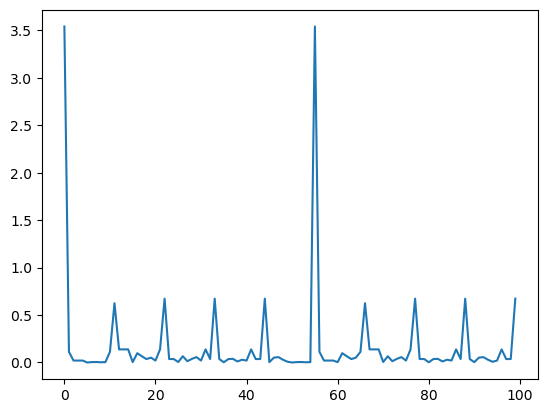

In [66]:
print(len(ethene.basis_functions))
t = ethene.twoel.reshape(10*10,10*10)
plt.plot(np.diag(t))

In [67]:
class hartree_fock(molecule):
    def initialize(self):
        self.nel = np.array([self.atomlist[i].get_atomic_number() for i in range(len(self.atomlist))]).sum()
        self.nocc = self.nel//2
        
        # precalculate integrals 
        self.getS()
        self.getT()
        self.getV()
        self.getTwoel()
        
        # orthogonalize AO
        eigval, eigvec = np.linalg.eigh(self.S)
        self.X = eigvec @ np.diag(1/np.sqrt(eigval))

        # core hamiltonian + initialize density matrix
        self.hcore = self.T + self.V
        orb_en, orb = np.linalg.eigh(self.hcore)
        
        C = orb[:, :self.nocc]
        self.P = C @ C.T
    
    def get_fock(self, P):
        G = np.einsum('kl, ijkl -> ij', P, 2 * self.twoel-self.twoel.transpose(0,2,1,3))
        return self.hcore + G
    
    def run_hf(self, max_iter = 100, threshold = 1e-6):
        energy_last_iteration = 0.0
        for iteration in range(max_iter):
            # calculate Fock-matrix
            F = self.get_fock(self.P)
            # orthogonalize Fock-Matrix
            F_ortho = self.X.T @ F @ self.X
            # diagonalize Fock-Matrix
            eigvals, eigvect = np.linalg.eigh(F_ortho)
            # get new density matrix 
            C = eigvect[:, :self.nocc]
            self.P = C @ C.T
            self.P = self.X @ self.P @ self.X.T
            # calculate energy 
            energy = np.trace((self.hcore + F) @ self.P)
            print(f"Iteration {iteration}, Energy = {energy} Hartree")
            print(f"MO energies: {eigvals}")
            if np.abs(energy - energy_last_iteration) < threshold:
                break
            energy_last_iteration = energy
        
            
            

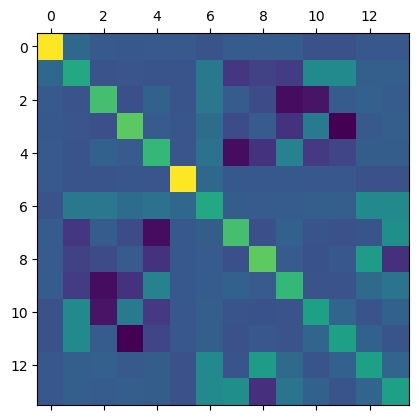

In [68]:
ethene = hartree_fock([])
ethene.read_from_XYZ(path = "./ethene.xyz")
ethene.get_basis()
ethene.initialize()
plt.matshow(ethene.P)

In [69]:
ethene.run_hf(threshold = 1e-8)

Iteration 0, Energy = -84.49350437087274 Hartree
MO energies: [-7.06486098 -7.02618232  1.47372385  1.62162733  1.83527284  2.02053237
  2.4712052   2.73421028  3.53702788  3.54043915  3.54234869  3.56430031
  4.09155384  4.59888517]
Iteration 1, Energy = -112.88526535021715 Hartree
MO energies: [-11.55762114 -11.55690726  -1.24515729  -0.84860813  -0.71958433
  -0.71532915  -0.61058312  -0.56176147   0.03944013   0.4562823
   0.53537021   0.5557357    0.68649408   0.74921821]
Iteration 2, Energy = -110.53571536421289 Hartree
MO energies: [-10.9933095  -10.99233727  -0.97034227  -0.73808035  -0.59782924
  -0.52347228  -0.45433631  -0.31651122   0.33929155   0.63015389
   0.70197672   0.70617321   0.95286375   1.02916869]
Iteration 3, Energy = -110.66320835538987 Hartree
MO energies: [-11.02255967 -11.02161368  -0.98425502  -0.74525701  -0.60491912
  -0.53643874  -0.46026813  -0.33196659   0.32380172   0.62266022
   0.69514631   0.69919259   0.94441598   1.00989365]
Iteration 4, Energy 

In [112]:
import pyscf
from pyscf import gto, scf
mol = gto.M(atom = "./ethene.xyz", basis = "sto-3g")
T_pyscf = mol.intor("int1e_kin", hermi = 1)
S_pyscf = mol.intor("int1e_ovlp", hermi = 1)
V_pyscf = mol.intor("int1e_nuc", hermi = 1)
eri_pyscf = mol.intor("int2e")

hf = scf.RHF(mol)
hf.kernel()
ehf = hf.e_tot
nuc_rep = mol.energy_nuc()
print(f"PySCF HF energy: {ehf - nuc_rep}")
mo_pyscf = hf.mo_energy
print(mo_pyscf)

converged SCF energy = -77.0737298527087
PySCF HF energy: -110.65678763727345
[-11.0209847  -11.02003742  -0.98372247  -0.74496446  -0.60437502
  -0.53604046  -0.45973179  -0.33125479   0.32457708   0.62314365
   0.69531433   0.69944473   0.94509262   1.01066293]


1.2895467841612873e-08 -6.790668303767477e-08 -6.565792002270884e-08
-0.5762099550330602 -0.18706167924130462 0.9087846587164622
0.45364303326283223 0.9920487103917075 0.05428664284304252
-0.6616312668918253 -0.05079887153371564 -0.8675039451863359
0.7841981757665788 -0.754188091710006 -0.09556729071525509


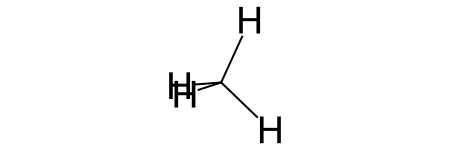

In [72]:
from rdkit import Chem
from rdkit.Chem import AllChem
et = Chem.MolFromSmiles('C')
et = Chem.AddHs(et)
AllChem.EmbedMolecule(et)
AllChem.MMFFOptimizeMolecule(et)
for atom in et.GetAtoms():
    pos = et.GetConformer().GetAtomPosition(atom.GetIdx())
    print(pos.x,pos.y,pos.z)
et

In [103]:
atoms = et.GetAtoms()
help(atoms)

Help on _ROAtomSeq in module rdkit.Chem.rdchem object:

class _ROAtomSeq(Boost.Python.instance)
 |  Read-only sequence of atoms, not constructible from Python.
 |  
 |  Method resolution order:
 |      _ROAtomSeq
 |      Boost.Python.instance
 |      builtins.object
 |  
 |  Static methods defined here:
 |  
 |  __getitem__(...)
 |      __getitem__( (_ROAtomSeq)arg1, (int)arg2) -> Atom :
 |      
 |          C++ signature :
 |              RDKit::Atom* __getitem__(RDKit::ReadOnlySeq<RDKit::AtomIterator_<RDKit::Atom, RDKit::ROMol>, RDKit::Atom*, RDKit::AtomCountFunctor> {lvalue},int)
 |  
 |  __init__(...)
 |      Raises an exception
 |      This class cannot be instantiated from Python
 |  
 |  __iter__(...)
 |      __iter__( (_ROAtomSeq)arg1) -> _ROAtomSeq :
 |      
 |          C++ signature :
 |              RDKit::ReadOnlySeq<RDKit::AtomIterator_<RDKit::Atom, RDKit::ROMol>, RDKit::Atom*, RDKit::AtomCountFunctor>* __iter__(RDKit::ReadOnlySeq<RDKit::AtomIterator_<RDKit::Atom, RDKit::

In [109]:
import mayavi